Loaded 9240 training sequences.
Loaded 4400 testing sequences.
Training sequences after filtering: 9178
Testing sequences after filtering: 4378
[SKIP] 001_nm_000.npy
[SKIP] 001_nm_018.npy
[SKIP] 001_nm_036.npy
[SKIP] 001_nm_054.npy
[SKIP] 001_nm_072.npy
[SKIP] 001_nm_090.npy
[SKIP] 001_nm_108.npy
[SKIP] 001_nm_126.npy
[SKIP] 001_nm_144.npy
[SKIP] 001_nm_162.npy
[SKIP] 001_nm_180.npy
[SKIP] 001_nm_000.npy
[SKIP] 001_nm_018.npy
[SKIP] 001_nm_036.npy
[SKIP] 001_nm_054.npy
[SKIP] 001_nm_072.npy
[SKIP] 001_nm_090.npy
[SKIP] 001_nm_108.npy
[SKIP] 001_nm_126.npy
[SKIP] 001_nm_144.npy
[SKIP] 001_nm_162.npy
[SKIP] 001_nm_180.npy
[SKIP] 001_nm_000.npy
[SKIP] 001_nm_018.npy
[SKIP] 001_nm_036.npy
[SKIP] 001_nm_054.npy
[SKIP] 001_nm_072.npy
[SKIP] 001_nm_090.npy
[SKIP] 001_nm_108.npy
[SKIP] 001_nm_126.npy
[SKIP] 001_nm_144.npy
[SKIP] 001_nm_162.npy
[SKIP] 001_nm_180.npy
[SKIP] 001_nm_000.npy
[SKIP] 001_nm_018.npy
[SKIP] 001_nm_036.npy
[SKIP] 001_nm_054.npy
[SKIP] 001_nm_072.npy
[SKIP] 001_nm_090.np

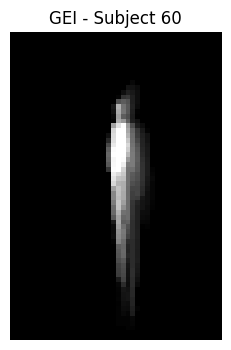

Epoch 1: Train loss 4.4811 | Val loss 8.4269 | Val acc 0.0000
Epoch 2: Train loss 4.2971 | Val loss 19.2235 | Val acc 0.0000
Epoch 3: Train loss 3.4178 | Val loss 34.1152 | Val acc 0.0000
Epoch 4: Train loss 2.5949 | Val loss 61.1543 | Val acc 0.0000
Epoch 5: Train loss 1.8245 | Val loss 69.5139 | Val acc 0.0000


KeyboardInterrupt: 

In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Paths and constants
IMG_HEIGHT = 64
IMG_WIDTH = 44
CACHE_DIR = "gei_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Load CASIA-B metadata
def load_casia_b_data(dataset_path):
    train_subjects = [f"{i:03d}" for i in range(1, 85)]
    test_subjects = [f"{i:03d}" for i in range(85, 125)]
    conditions = {
        'nm': ['nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'],
        'bg': ['bg-01','bg-02'],
        'cl': ['cl-01','cl-02']
    }
    views = [f"{i:03d}" for i in range(0, 181, 18)]
    def gather_entries(subject_list):
        entries = []
        for subject in subject_list:
            subj_path = os.path.join(dataset_path, subject)
            if not os.path.isdir(subj_path):
                continue
            for cond, seqs in conditions.items():
                for seq in seqs:
                    seq_path = os.path.join(subj_path, seq)
                    if not os.path.isdir(seq_path):
                        continue
                    for view in views:
                        view_path = os.path.join(seq_path, view)
                        if not os.path.isdir(view_path):
                            continue
                        frames = [f for f in os.listdir(view_path) if f.endswith('.png')]
                        entries.append({
                            'subject': subject,
                            'condition': cond,
                            'sequence': seq,
                            'view': view,
                            'path': view_path,
                            'num_frames': len(frames)
                        })
        return entries
    train_data = gather_entries(train_subjects)
    test_data = gather_entries(test_subjects)
    print(f"Loaded {len(train_data)} training sequences.")
    print(f"Loaded {len(test_data)} testing sequences.")
    return train_data, test_data

train_data, test_data = load_casia_b_data(r'D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh')

MIN_SEQ_LEN = 10
train_data = [e for e in train_data if e['num_frames'] >= MIN_SEQ_LEN]
test_data = [e for e in test_data if e['num_frames'] >= MIN_SEQ_LEN]
print(f"Training sequences after filtering: {len(train_data)}")
print(f"Testing sequences after filtering: {len(test_data)}")

# GEI creation and caching
def create_gei_from_sequence(sequence_path):
    frame_files = sorted([f for f in os.listdir(sequence_path) if f.endswith('.png')])
    gei = None
    frame_count = 0
    for frame_file in frame_files:
        frame = cv2.imread(os.path.join(sequence_path, frame_file), cv2.IMREAD_GRAYSCALE)
        if gei is None:
            gei = np.zeros_like(frame, dtype=np.float32)
        gei += frame.astype(np.float32) / 255.0
        frame_count += 1
    if frame_count > 0:
        gei /= frame_count
    return (gei * 255).astype(np.uint8)

def cache_one(ent):
    cache_name = f"{ent['subject']}_{ent['condition']}_{ent['view']}.npy"
    cache_path = os.path.join(CACHE_DIR, cache_name)
    if os.path.exists(cache_path):
        print(f"[SKIP] {cache_name}")
        return
    print(f"[START] {cache_name}")
    gei = create_gei_from_sequence(ent['path'])
    gei = cv2.resize(gei, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    np.save(cache_path, gei)
    print(f"[DONE ] {cache_name}")

def get_or_create_gei(sequence_path, subject, condition, view):
    cache_name = f"{subject}_{condition}_{view}.npy"
    cache_path = os.path.join(CACHE_DIR, cache_name)
    if os.path.exists(cache_path):
        return np.load(cache_path)
    cache_one({'path': sequence_path, 'subject': subject, 'condition': condition, 'view': view})
    return np.load(cache_path)

def build_dataset(entries):
    X_list, y_list = [], []
    for ent in entries:
        gei = get_or_create_gei(ent['path'], ent['subject'], ent['condition'], ent['view'])
        X_list.append(gei)
        y_list.append(int(ent['subject']) - 1)
    X = np.stack(X_list, axis=0)[..., None]  # (N, H, W, 1)
    y = np.array(y_list, dtype=np.int32)
    return X, y

# -- Cache all GEIs and build the datasets
all_entries = train_data + test_data
for ent in all_entries:
    cache_one(ent)
X_train, y_train = build_dataset(train_data)
X_test, y_test   = build_dataset(test_data)
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Optionally save for reload later
os.makedirs('processed_gei', exist_ok=True)
np.save('processed_gei/X_train.npy', X_train)
np.save('processed_gei/y_train.npy', y_train)
np.save('processed_gei/X_test.npy', X_test)
np.save('processed_gei/y_test.npy', y_test)

# Visualization
i = np.random.randint(0, X_train.shape[0])
gei = X_train[i, :, :, 0]
plt.figure(figsize=(4,4))
plt.imshow(gei, cmap='gray')
plt.title(f"GEI - Subject {y_train[i]}")
plt.axis('off')
plt.show()

# PyTorch Dataset objects
class GEIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Convert shape: (H, W, 1) -> (1, H, W)
        img = self.X[idx].permute(2, 0, 1)
        label = self.y[idx]
        return img, label

train_dataset = GEIDataset(X_train, y_train)
test_dataset  = GEIDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=4)

# PyTorch model (matching your TensorFlow structure)
class GEICNN(nn.Module):
    def __init__(self, num_classes, height, width):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear((height // 4) * (width // 4) * 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

NUM_CLASSES = len(np.unique(np.concatenate([y_train, y_test])))
HEIGHT = X_train.shape[1]
WIDTH  = X_train.shape[2]
model = GEICNN(NUM_CLASSES, HEIGHT, WIDTH)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
EPOCHS = 10
patience = 10
best_loss = float('inf')
counter = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * Xb.size(0)
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1}: Train loss {train_loss:.4f} | Val loss {val_loss:.4f} | Val acc {val_acc:.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'gei_cnn_best.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break

print("Training completed!")


In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 44
CACHE_DIR = "gei_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# Load CASIA-B metadata
def load_casia_b_data(dataset_path):
    train_subjects = [f"{i:03d}" for i in range(1, 85)]
    test_subjects = [f"{i:03d}" for i in range(85, 125)]
    conditions = {
        'nm': ['nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'],
        'bg': ['bg-01','bg-02'],
        'cl': ['cl-01','cl-02']
    }
    views = [f"{i:03d}" for i in range(0, 181, 18)]
    def gather_entries(subject_list):
        entries = []
        for subject in subject_list:
            subj_path = os.path.join(dataset_path, subject)
            if not os.path.isdir(subj_path):
                continue
            for cond, seqs in conditions.items():
                for seq in seqs:
                    seq_path = os.path.join(subj_path, seq)
                    if not os.path.isdir(seq_path):
                        continue
                    for view in views:
                        view_path = os.path.join(seq_path, view)
                        if not os.path.isdir(view_path):
                            continue
                        frames = [f for f in os.listdir(view_path) if f.endswith('.png')]
                        entries.append({
                            'subject': subject,
                            'condition': cond,
                            'sequence': seq,
                            'view': view,
                            'path': view_path,
                            'num_frames': len(frames)
                        })
        return entries
    train_data = gather_entries(train_subjects)
    test_data = gather_entries(test_subjects)
    print(f"Loaded {len(train_data)} training sequences.")
    print(f"Loaded {len(test_data)} testing sequences.")
    return train_data, test_data

train_data, test_data = load_casia_b_data(r'D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh')


In [ ]:

MIN_SEQ_LEN = 10
train_data = [e for e in train_data if e['num_frames'] >= MIN_SEQ_LEN]
test_data = [e for e in test_data if e['num_frames'] >= MIN_SEQ_LEN]
print(f"Training sequences after filtering: {len(train_data)}")
print(f"Testing sequences after filtering: {len(test_data)}")


In [ ]:
# GEI creation and caching
def create_gei_from_sequence(sequence_path):
    frame_files = sorted([f for f in os.listdir(sequence_path) if f.endswith('.png')])
    gei = None
    frame_count = 0
    for frame_file in frame_files:
        frame = cv2.imread(os.path.join(sequence_path, frame_file), cv2.IMREAD_GRAYSCALE)
        if gei is None:
            gei = np.zeros_like(frame, dtype=np.float32)
        gei += frame.astype(np.float32) / 255.0
        frame_count += 1
    if frame_count > 0:
        gei /= frame_count
    return (gei * 255).astype(np.uint8)

def cache_one(ent):
    cache_name = f"{ent['subject']}_{ent['condition']}_{ent['view']}.npy"
    cache_path = os.path.join(CACHE_DIR, cache_name)
    if os.path.exists(cache_path):
        print(f"[SKIP] {cache_name}")
        return
    print(f"[START] {cache_name}")
    gei = create_gei_from_sequence(ent['path'])
    gei = cv2.resize(gei, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
    np.save(cache_path, gei)
    print(f"[DONE ] {cache_name}")


In [ ]:
def get_or_create_gei(sequence_path, subject, condition, view):
    cache_name = f"{subject}_{condition}_{view}.npy"
    cache_path = os.path.join(CACHE_DIR, cache_name)
    if os.path.exists(cache_path):
        return np.load(cache_path)
    cache_one({'path': sequence_path, 'subject': subject, 'condition': condition, 'view': view})
    return np.load(cache_path)

def build_dataset(entries):
    X_list, y_list = [], []
    for ent in entries:
        gei = get_or_create_gei(ent['path'], ent['subject'], ent['condition'], ent['view'])
        X_list.append(gei)
        y_list.append(int(ent['subject']) - 1)
    X = np.stack(X_list, axis=0)[..., None]  # (N, H, W, 1)
    y = np.array(y_list, dtype=np.int32)
    return X, y


In [ ]:
all_entries = train_data + test_data
for ent in all_entries:
    cache_one(ent)
X_train, y_train = build_dataset(train_data)
X_test, y_test   = build_dataset(test_data)
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Optionally save for reload later
os.makedirs('processed_gei', exist_ok=True)
np.save('processed_gei/X_train.npy', X_train)
np.save('processed_gei/y_train.npy', y_train)
np.save('processed_gei/X_test.npy', X_test)
np.save('processed_gei/y_test.npy', y_test)


In [ ]:
# Visualization
i = np.random.randint(0, X_train.shape[0])
gei = X_train[i, :, :, 0]
plt.figure(figsize=(4,4))
plt.imshow(gei, cmap='gray')
plt.title(f"GEI - Subject {y_train[i]}")
plt.axis('off')
plt.show()


In [ ]:
class GEIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Convert shape: (H, W, 1) -> (1, H, W)
        img = self.X[idx].permute(2, 0, 1)
        label = self.y[idx]
        return img, label

train_dataset = GEIDataset(X_train, y_train)
test_dataset  = GEIDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=4)


In [ ]:
class GEICNN(nn.Module):
    def __init__(self, num_classes, height, width):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear((height // 4) * (width // 4) * 128, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
NUM_CLASSES = len(np.unique(np.concatenate([y_train, y_test])))
HEIGHT = X_train.shape[1]
WIDTH  = X_train.shape[2]
model = GEICNN(NUM_CLASSES, HEIGHT, WIDTH)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training loop
EPOCHS = 10
patience = 10
best_loss = float('inf')
counter = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            val_loss += loss.item() * Xb.size(0)
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc = correct / len(test_loader.dataset)
    print(f'Epoch {epoch+1}: Train loss {train_loss:.4f} | Val loss {val_loss:.4f} | Val acc {val_acc:.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'gei_cnn_best.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break

print("Training completed!")